Before running this notebook, data has to be loaded with the notebook:
* 01-data_loading.ipynb

Kernel used for running: **Python 3.8**

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm.auto import tqdm
import pickle

import matplotlib.colors
import matplotlib.patches as patches
import matplotlib.cm as cm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from ipynb.fs.full.Utility_functions import (draw_pitch, create_heatmap, draw_pass_map,
                                             get_openplay_xg_assisted, get_minutes_played,
                                             get_total_minutes, calculate_ppda,
                                             compute_def_actions, FreeCompetitions)

In [2]:
import sys
sys.path.insert(0, '../')

import config

### Load data

In [3]:
df_messi = pd.read_csv('../data/df_messi.csv', index_col=0, low_memory=False)

with open('../data/match_ids_no_stats.pkl', 'rb') as f:
    match_id_no_stats = pickle.load(f)
    
messi_name = config.player_name
derby_folder = config.folder_derby

/home/ysance.local/benjamin.larrousse/Envs/env_statsbomb_38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
messi_result = pd.read_csv('../data/messi_stats.csv', index_col=0)

messi_result.head()

,match_id,match_date,kick_off,home_score,away_score,match_status,last_updated,match_week,competition.competition_id,competition.country_name,competition.competition_name,season.season_id,season.season_name,home_team.home_team_id,home_team.home_team_name,home_team.home_team_gender,home_team.home_team_group,home_team.country.id,home_team.country.name,home_team.managers,away_team.away_team_id,away_team.away_team_name,away_team.away_team_gender,away_team.away_team_group,away_team.country.id,away_team.country.name,away_team.managers,metadata.data_version,metadata.shot_fidelity_version,competition_stage.id,competition_stage.name,stadium.id,stadium.name,stadium.country.id,stadium.country.name,referee.id,referee.name,referee.country.id,referee.country.name,metadata.xy_fidelity_version,Goal_difference,barca_result
0,16215,2019-03-17,20:45:00.000,1,4,available,2019-12-16T23:09:16.168756,28,11,Spain,La Liga,4,2018/2019,218,Real Betis,male,NaN,214,Spain,"[{'id': 238, 'name': 'Enrique Setién Solar', '...",217,Barcelona,male,NaN,214,Spain,"[{'id': 227, 'name': 'Ernesto Valverde Tejedor...",1.1.0,2,1,Regular Season,352.0,Estadio Benito Villamarín,214.0,Spain,215.0,Ricardo De Burgos,112.0,Italy,NaN,-3,Win
1,16196,2019-03-02,20:45:00.000,0,1,available,2019-12-16T23:09:16.168756,26,11,Spain,La Liga,4,2018/2019,220,Real Madrid,male,NaN,214,Spain,"[{'id': 25, 'name': 'Santiago Hernán Solari Po...",217,Barcelona,male,NaN,214,Spain,"[{'id': 227, 'name': 'Ernesto Valverde Tejedor...",1.1.0,2,1,Regular Season,353.0,Estadio Santiago Bernabéu,214.0,Spain,221.0,Alberto Undiano,112.0,Italy,NaN,-1,Win
2,16205,2019-03-09,18:30:00.000,3,1,available,2019-12-16T23:09:16.168756,27,11,Spain,La Liga,4,2018/2019,217,Barcelona,male,NaN,214,Spain,"[{'id': 227, 'name': 'Ernesto Valverde Tejedor...",360,Rayo Vallecano,male,NaN,214,Spain,"[{'id': 766, 'name': 'Miguel Ángel Sánchez Muñ...",1.1.0,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,209.0,Mario Melero,112.0,Italy,NaN,2,Win
3,16131,2019-01-13,18:30:00.000,3,0,available,2019-12-16T23:09:16.168756,19,11,Spain,La Liga,4,2018/2019,217,Barcelona,male,NaN,214,Spain,"[{'id': 227, 'name': 'Ernesto Valverde Tejedor...",322,Eibar,male,NaN,214,Spain,"[{'id': 765, 'name': 'Andoni Azkargorta Gezala...",1.0.3,2,1,Regular Season,342.0,Camp Nou,214.0,Spain,183.0,Jesús Gil,214.0,Spain,NaN,3,Win
4,16149,2019-01-27,16:15:00.000,0,2,available,2019-12-16T23:09:16.168756,21,11,Spain,La Liga,4,2018/2019,211,Girona,male,NaN,214,Spain,"[{'id': 229, 'name': 'Eusebio Sacristán Mena',...",217,Barcelona,male,NaN,214,Spain,"[{'id': 227, 'name': 'Ernesto Valverde Tejedor...",1.0.3,2,1,Regular Season,343.0,Estadi Municipal de Montilivi,214.0,Spain,219.0,Pablo González,112.0,Italy,NaN,-2,Win


In [5]:
free_comp = FreeCompetitions(env='local')

free_comp.head()

,competition_id,season_id,country_name,competition_name,competition_gender,season_name,match_updated,match_available
0,37,42,England,FA Women's Super League,female,2019/2020,2020-03-11T14:09:41.932138,2020-03-11T14:09:41.932138
1,37,4,England,FA Women's Super League,female,2018/2019,2020-02-27T15:59:58.148,2020-02-27T15:59:58.148
2,43,3,International,FIFA World Cup,male,2018,2019-12-16T23:09:16.168756,2019-12-16T23:09:16.168756
3,11,4,Spain,La Liga,male,2018/2019,2020-02-27T12:19:39.458017,2020-02-27T12:19:39.458017
4,11,1,Spain,La Liga,male,2017/2018,2020-02-27T12:19:39.458017,2020-02-27T12:19:39.458017


In [6]:
# List of match_id from the 2009/2010 season
match_id_0910 = messi_result[messi_result['season.season_id'] == 21]['match_id'].values

### Defensive analysis


In [7]:
# Calculate number of defensive actions per pitch zones

# Cutting the pitch
x_min_cut = range(0, 120, 20)
x_max_cut = range(20, 121, 20)
y_min_cut = range(0, 80, 16)
y_max_cut = range(16, 81, 16)

# Empty dataframe creation for results
def_actions_0910 = pd.DataFrame(columns=['match_id','x_min', 'x_max',
                                         'y_min', 'y_max',
                                         'def_barca', 'def_opponent'])

# Calculation of defensive actions for all matches from 2009/2010
for match_id in tqdm(match_id_0910):
    def_actions = []
    for x_min, x_max in zip(x_min_cut, x_max_cut):
        for y_min, y_max in zip(y_min_cut, y_max_cut):
            def_window = compute_def_actions(df_messi,
                                             match_id,
                                             x_min, x_max,
                                             y_min, y_max)
            opponent = [list(def_window.keys()
                             )[0] if list(def_window.keys()
                                          )[0] != 'Barcelona' else list(def_window.keys()
                                                                        )[1]][0]
            def_actions.append([match_id, x_min, x_max, y_min, y_max,
                                def_window['Barcelona'],
                                def_window[opponent]
                                ])

    temp_df = pd.DataFrame(data=def_actions,
                           columns=['match_id','x_min', 'x_max',
                                    'y_min', 'y_max',
                                    'def_barca', 'def_opponent'])

    def_actions_0910 = def_actions_0910.append(temp_df, ignore_index=True)

def_actions_0910.head()

,match_id,x_min,x_max,y_min,y_max,def_barca,def_opponent
0,69239,0,20,0,16,10,7
1,69239,0,20,16,32,10,11
2,69239,0,20,32,48,6,11
3,69239,0,20,48,64,0,5
4,69239,0,20,64,80,3,0


In [8]:
# Compute the average number of defensive actions per pitch zone
# Average value for Barca on one side and for its opponents on the other side
def_means = []
for x_min, x_max in zip(x_min_cut, x_max_cut):
    for y_min, y_max in zip(y_min_cut, y_max_cut):
        means = def_actions_0910[(def_actions_0910['x_min'] == x_min) &
                                 (def_actions_0910['x_max'] == x_max) &
                                 (def_actions_0910['y_min'] == y_min) &
                                 (def_actions_0910['y_max'] == y_max)
                                 ][['def_barca', 'def_opponent']].mean()
        
        def_means.append([x_min, x_max, y_min, y_max,
                          means['def_barca'],
                          means['def_opponent']
                          ])
    
def_actions_0910_mean = pd.DataFrame(data=def_means,
                                     columns=['x_min', 'x_max',
                                              'y_min', 'y_max',
                                              'def_barca', 'def_opponent'])

def_actions_0910_mean.head()

,x_min,x_max,y_min,y_max,def_barca,def_opponent
0,0,20,0,16,6.028571,4.714286
1,0,20,16,32,6.228571,9.942857
2,0,20,32,48,9.542857,17.000000
3,0,20,48,64,6.857143,12.257143
4,0,20,64,80,7.085714,7.057143


In [9]:
# xG p90 2009/2010 season:
xg_mean_0910 = 90 * df_messi[(df_messi['season_id'] == 21) &
                        (df_messi['player.name'] == messi_name)
                        ]['shot.statsbomb_xg'].sum() / get_total_minutes(df_messi,
                                                                         21,
                                                                         messi_name,
                                                                         'Barcelona')

xg_mean_0910

0.7506916970861887

In [10]:
# Game with smallest xG value from Messi
# 09/10 season
#xG per90
xg_0910 = df_messi[(df_messi['match_id'].isin(match_id_0910)) &
                   (df_messi['player.name'] == messi_name)
                   ].groupby('match_id')['shot.statsbomb_xg'].sum()


xg_0910_per90 = pd.Series(data=[90 * xg_0910[x] / get_minutes_played(df_messi, 
                                                                     x, 
                                                                     messi_name,
                                                                     'Barcelona'
                                                                     ) for x in xg_0910.index],
                          index=xg_0910.index)


index_min_xg = xg_0910_per90.argmin()

match_id_min_xg = xg_0910_per90.index[index_min_xg]

match_id_min_xg

69213

In [11]:
messi_result[messi_result['match_id'] == match_id_min_xg][['home_score', 'away_score',
                                                           'home_team.home_team_name',
                                                           'away_team.away_team_name']]

,home_score,away_score,home_team.home_team_name,away_team.away_team_name
318,0,0,Espanyol,Barcelona


### Espanyol - Barcelona 2009/2010

In [12]:
# xG of Barcelona in the derby
df_messi[(df_messi['match_id'] == match_id_min_xg) &
         (df_messi['team.name'] == 'Barcelona')]['shot.statsbomb_xg'].sum()

0.10748693

In [13]:
# xG of Espanyol in the derby
df_messi[(df_messi['match_id'] == match_id_min_xg) &
         (df_messi['team.name'] == 'Espanyol') &
         (df_messi['type.name'] == 'Shot')
         ]['shot.statsbomb_xg'].sum()

0.6103297089999999

#### Defensive visualisation

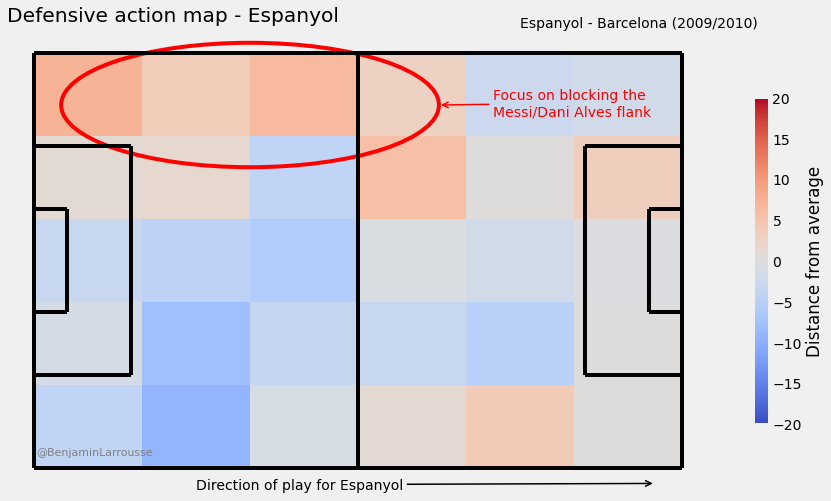

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
draw_pitch(ax)

minima = -20
maxima = 20

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap= 'coolwarm')

plt.colorbar(mapper, shrink=0.7, label='Distance from average')

# Visualization of defensive actions of Espanyol
# Number of actions compared to average numbers of Barcelona's opponents (season 2009/2010)
for index, row in def_actions_0910[def_actions_0910['match_id'] == match_id_min_xg].iterrows():
    mean_def = def_actions_0910_mean[(def_actions_0910_mean['x_min'] == row['x_min']) &
                                     (def_actions_0910_mean['x_max'] == row['x_max']) &
                                     (def_actions_0910_mean['y_min'] == row['y_min']) &
                                     (def_actions_0910_mean['y_max'] == row['y_max'])
                                     ]['def_opponent'].values[0]

    # Create a Rectangle patch
    rect = patches.Rectangle((row['x_min'], row['y_min']),
                             row['x_max'] - row['x_min'],
                             row['y_max'] - row['y_min'],
                             linewidth=1,
                             edgecolor='none',
                             facecolor=mapper.to_rgba(row['def_opponent']-mean_def),
                             )

    # Add the patch to the Axes
    ax.add_patch(rect)

    
ax.add_patch(patches.Ellipse((40, 10),
                             width=70,
                             height=24,
                             edgecolor='red',
                             fill=False,
                             linewidth=4
                             )
             )

ax.annotate("Focus on blocking the \nMessi/Dani Alves flank",
            xy=(75, 10), xytext=(85, 12),
            arrowprops=dict(arrowstyle="->", edgecolor='r', linewidth=1.5),
            color='r')

ax.set_title("Defensive action map - Espanyol",
             loc='left')

ax.annotate(f"Espanyol - Barcelona (2009/2010)",
            xy=(90, -5))

ax.annotate("Direction of play for Espanyol",
            xy=(115, 83), xytext=(30, 84),
            arrowprops=dict(arrowstyle="->", edgecolor='k', linewidth=1.5),
            color='k')

fig.savefig(derby_folder + 'espanyol_defensive_map.png')

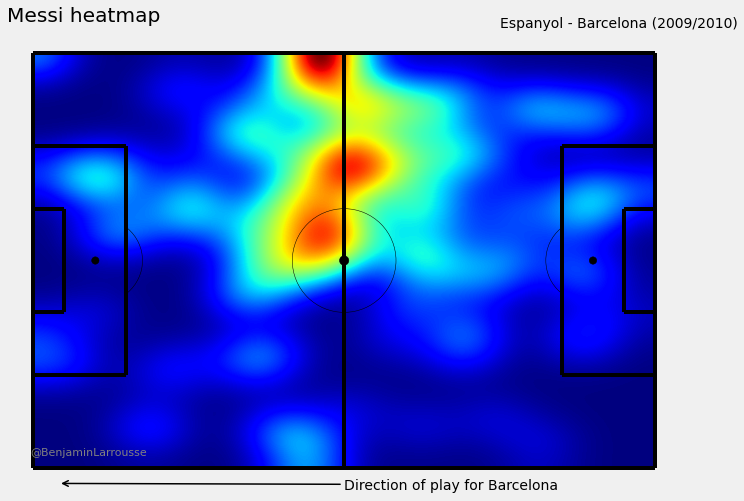

In [15]:
# Messi heatmap to compare to.
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
draw_pitch(ax)

example_data = df_messi[(df_messi['match_id'] == match_id_min_xg) &
                        (df_messi['player.name'] == messi_name) &
                        (~df_messi['location_x'].isnull()) &
                        (~df_messi['location_y'].isnull())]

sigma = 50

img, extent = create_heatmap(120 - example_data['location_x'],
                             80 - example_data['location_y'],
                             sigma)
ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
ax.set_title("Messi heatmap",
             loc='left')

ax.annotate(f"Espanyol - Barcelona (2009/2010)",
            xy=(90, -5))

ax.annotate("Direction of play for Barcelona",
            xy=(5, 83), xytext=(60, 84),
            arrowprops=dict(arrowstyle="->", edgecolor='k', linewidth=1.5),
            color='k')

fig.savefig(derby_folder + 'messi_heatmap.png')

#### Messi xG assisted

In [16]:
xg_assisted_p90 = pd.DataFrame(
    data=[90 * get_openplay_xg_assisted(df_messi,
                                        21,
                                        messi_name,
                                        [x]
                                        ) / get_minutes_played(df_messi,
                                                               x,
                                                               messi_name,
                                                               'Barcelona') for x in match_id_0910],
    index=match_id_0910,
    columns=['xG assisted'])

In [17]:
print(f"""xG assisted by Messi:
* Average 2009/2010: {xg_assisted_p90['xG assisted'].mean():.2f}
* Espanyol/Barcelona: {xg_assisted_p90[xg_assisted_p90.index == match_id_min_xg].values[0][0]:.2f}
""")

xG assisted by Messi:
* Average 2009/2010: 0.23
* Espanyol/Barcelona: 0.03



#### Messi pass map

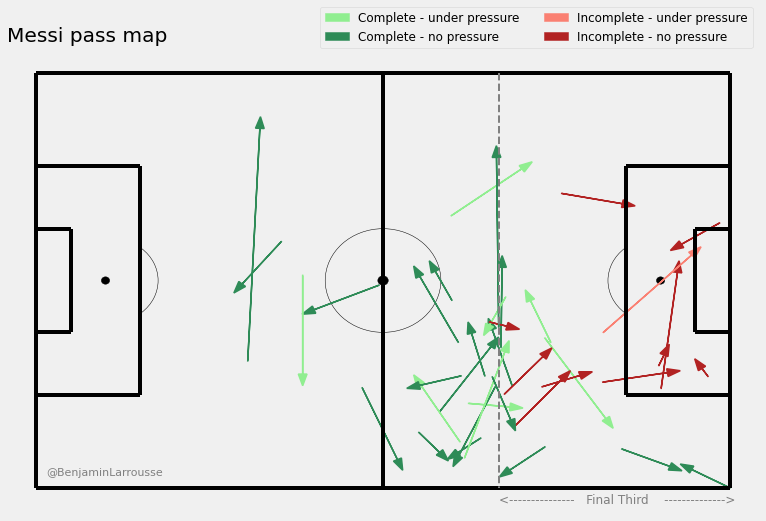

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
draw_pitch(ax)

for index, row in df_messi[(df_messi['match_id'] == match_id_min_xg) &
                           (df_messi['player.name'] == messi_name) & 
                           (df_messi['type.name'] == 'Pass')
                           ].iterrows():
    if row['pass.outcome.name'] == 'Incomplete':
        if row['under_pressure'] == True:
            color = "salmon"
        else:
            color = "firebrick"
    else:
        if row['under_pressure'] == True:
            color = 'lightgreen'
        else:
            color = 'seagreen'
            
    ax.arrow(row['location_x'],
             row['location_y'],
             row['end_location_x'] - row['location_x'],
             row['end_location_y'] - row['location_y'],
             color=color,
             linewidth=1.5,
             head_width=1.5,
             length_includes_head=True
             )
    
greenPatch_up = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'lightgreen')
redPatch_up = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'salmon')

greenPatch = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'seagreen')
redPatch = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'firebrick')

leg = ax.legend([greenPatch_up, greenPatch, redPatch_up, redPatch],
                ['Complete - under pressure', 'Complete - no pressure',
                 'Incomplete - under pressure', 'Incomplete - no pressure'],
                loc='upper right',
                bbox_to_anchor = (1, 1.1),
                fontsize=12,
                ncol=2)

plt.plot([80, 80], [0, 80],
         color='grey',
         linewidth=2,
         linestyle='--'
         )

plt.text(80, 83, "<---------------   Final Third    -------------->",
         {'color': 'grey', 'fontsize': 12})


ax.set_title("Messi pass map",
             loc='left')

fig.savefig(derby_folder + 'messi_pass_map.png')

#### Messi carry map 

In [19]:
# Percentage of carry under pressure for Messi in the derby
pressure_ratio_carry = len(
    df_messi[(df_messi['match_id'] == match_id_min_xg) &
             (df_messi['player.name'] == messi_name) & 
             (df_messi['type.name'] == 'Carry') &
             (df_messi['under_pressure'] == True)
             ]) / len(df_messi[(df_messi['match_id'] == match_id_min_xg) &
                               (df_messi['player.name'] == messi_name) & 
                               (df_messi['type.name'] == 'Carry')
                               ])

pressure_ratio_carry

0.6153846153846154

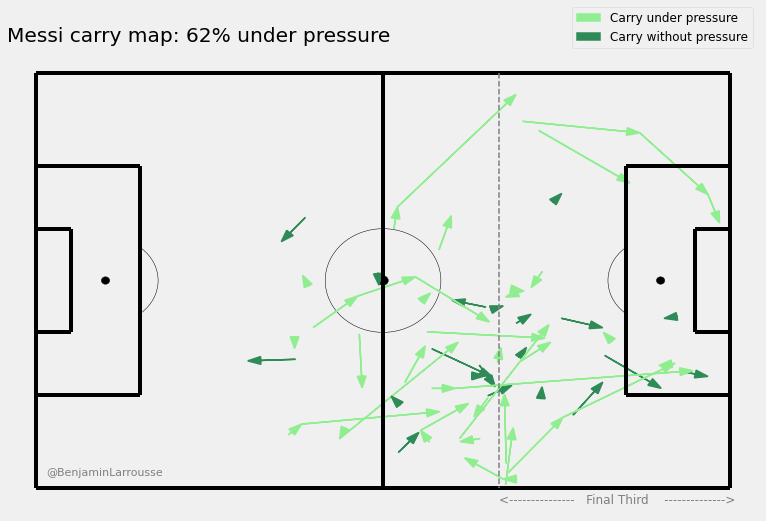

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
draw_pitch(ax)

for index, row in df_messi[(df_messi['match_id'] == match_id_min_xg) &
                           (df_messi['player.name'] == messi_name) & 
                           (df_messi['type.name'] == 'Carry')
                           ].iterrows():

    if row['under_pressure'] == True:
        color = 'lightgreen'
    else:
        color = 'seagreen'

    ax.arrow(row['location_x'],
             row['location_y'],
             row['end_location_x'] - row['location_x'],
             row['end_location_y'] - row['location_y'],
             color=color,
             linewidth=1.5,
             head_width=1.5,
             length_includes_head=True
             )
    
greenPatch_up = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'lightgreen')
greenPatch = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'seagreen')

leg = ax.legend([greenPatch_up, greenPatch],
                ['Carry under pressure', 'Carry without pressure'],
                loc='upper right',
                bbox_to_anchor = (1, 1.1),
                fontsize=12)

plt.plot([80, 80], [0, 80],
         color='grey',
         linewidth=1.5,
         linestyle='--'
         )

plt.text(80, 83, "<---------------   Final Third    -------------->",
         {'color': 'grey', 'fontsize': 12})

ax.set_title(f"Messi carry map: {100*pressure_ratio_carry:.0f}% under pressure",
            loc='left')


fig.savefig(derby_folder + 'messi_carry_map.png')

#### Passing networks

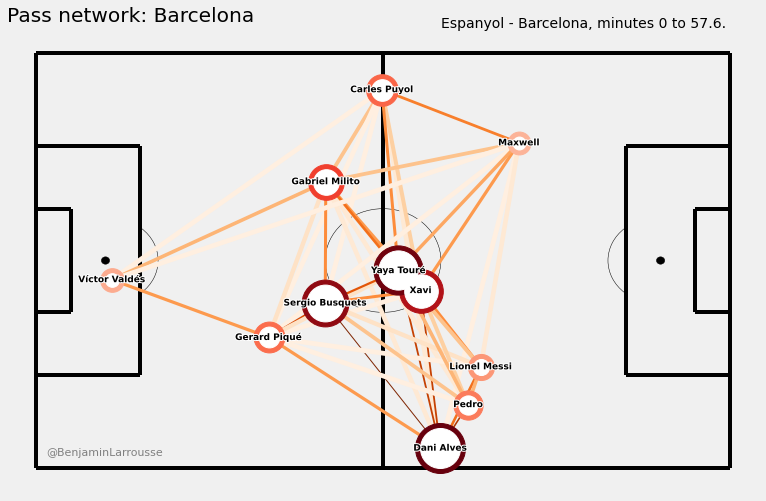

In [21]:
fig = plt.figure()
ax = fig.add_subplot()

fig.set_size_inches(12, 8)
draw_pitch(ax)

draw_pass_map(ax, df_messi, match_id_min_xg, 'Barcelona')

fig.savefig(derby_folder + 'pass_network_barcelona_before_redcard.png')

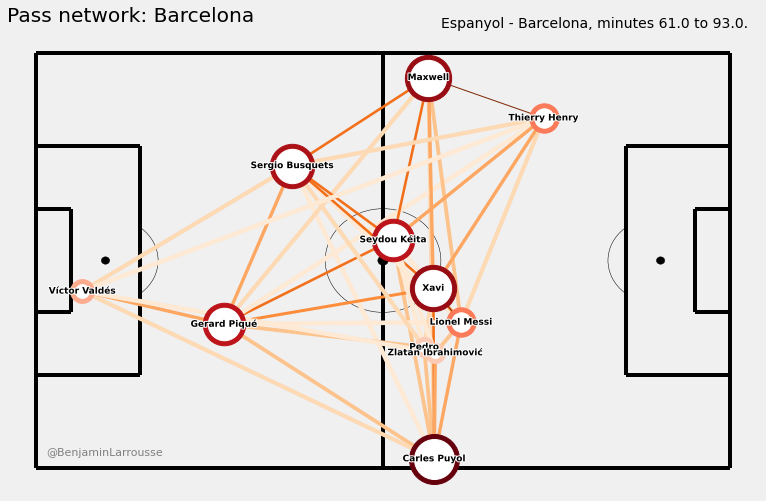

In [22]:
red_card = df_messi[(df_messi['match_id'] == match_id_min_xg) &
                    (df_messi['foul_committed.card.name'] == 'Second Yellow')
                    ]['time'].values[0]

fig = plt.figure()
ax = fig.add_subplot()

fig.set_size_inches(12, 8)
draw_pitch(ax)

draw_pass_map(ax, df_messi, match_id_min_xg, 'Barcelona',
              min_time=red_card,
              max_time=df_messi[df_messi['match_id'] == match_id_min_xg]['time'].max()
              )

fig.savefig(derby_folder + 'pass_network_barcelona_after_redcard.png')

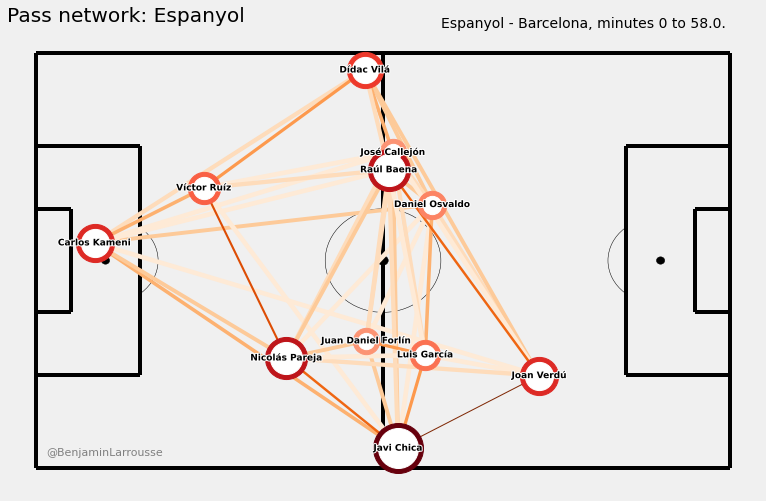

In [23]:
fig = plt.figure()
ax = fig.add_subplot()

fig.set_size_inches(12, 8)
draw_pitch(ax)

draw_pass_map(ax, df_messi, match_id_min_xg, 'Espanyol',max_time=58.0)

fig.savefig(derby_folder + 'pass_network_espanyol_before_redcard.png')

### Extra

Analysis that are not in the article.

#### Espanyol pressure heatmap

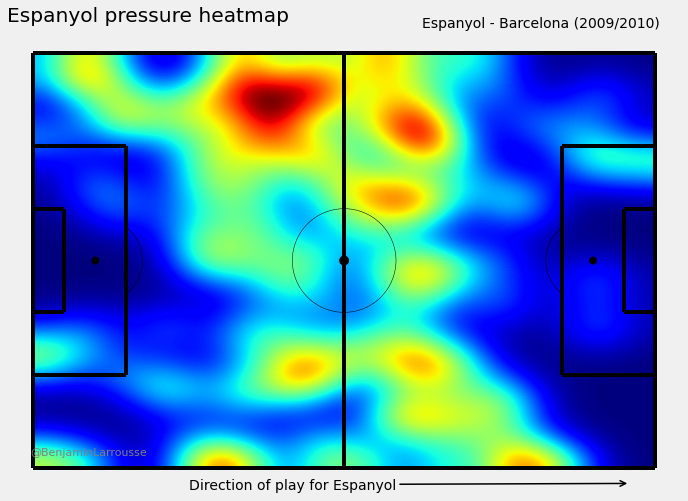

In [24]:
fig = plt.figure()
ax = fig.add_subplot()

fig.set_size_inches(12, 8)
draw_pitch(ax)

pressure_data = df_messi[(df_messi['match_id'] == match_id_min_xg) &
                         (df_messi['team.name'] == 'Espanyol') &
                         (df_messi['type.name'] == 'Pressure')
                         ]

sigma = 50

img, extent = create_heatmap(pressure_data['location_x'],
                             pressure_data['location_y'],
                             sigma)
ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)

ax.set_title("Espanyol pressure heatmap",
            loc='left')

ax.annotate(f"Espanyol - Barcelona (2009/2010)",
            xy=(75, -5))

ax.annotate("Direction of play for Espanyol",
            xy=(115, 83), xytext=(30, 84),
            arrowprops=dict(arrowstyle="->", edgecolor='k', linewidth=1.5),
            color='k')

fig.savefig(derby_folder + 'espanyol_frequency_pressure_map.png')

#### Barcelona Snap-shots
Only 4 shots in the entire game, and not good ones

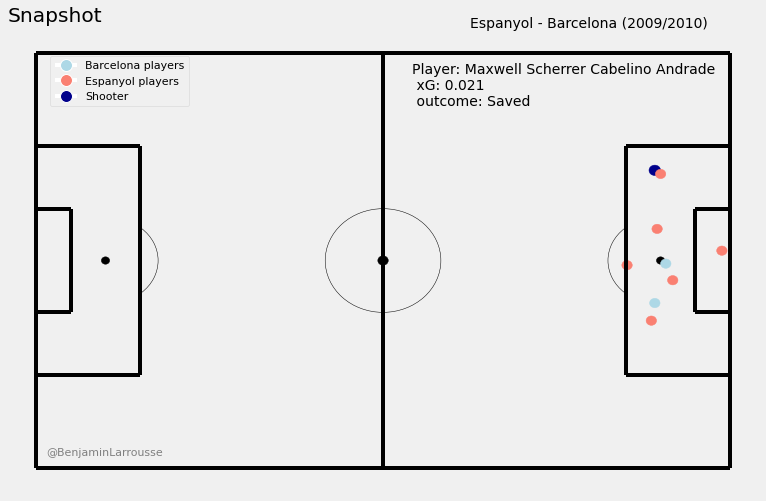

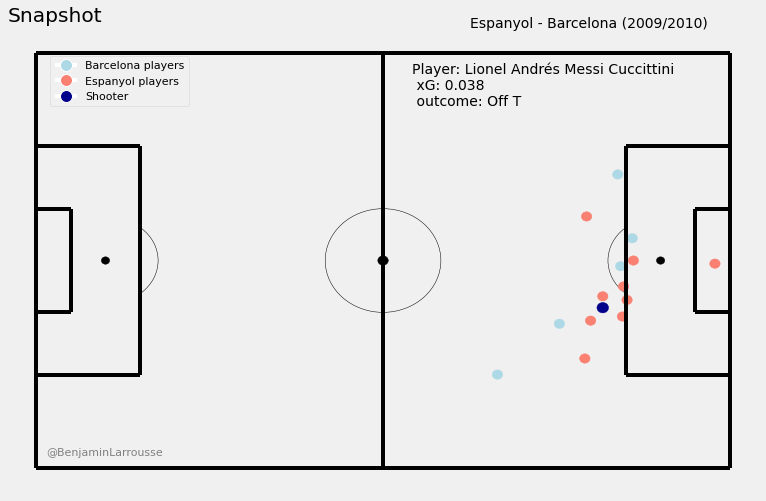

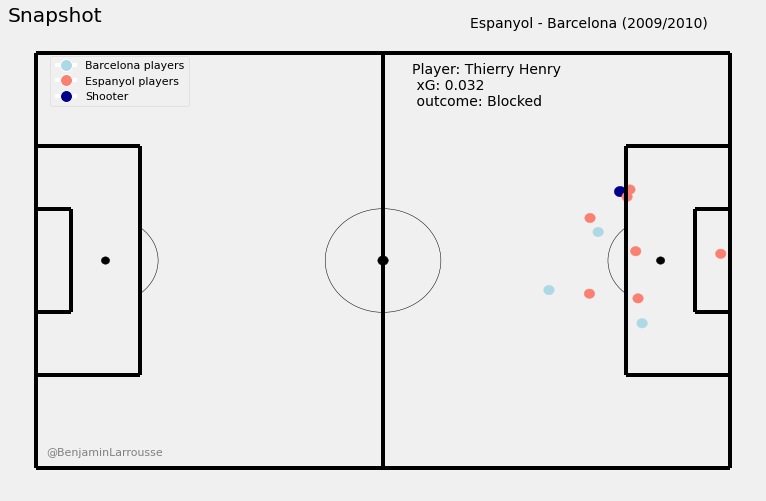

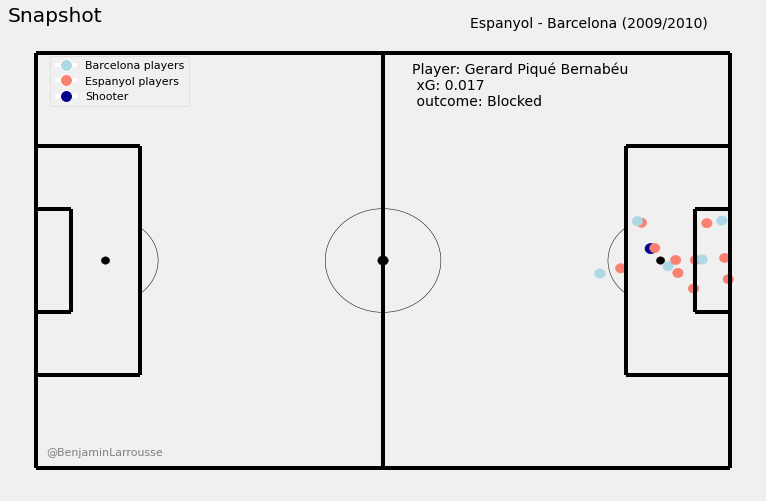

In [25]:
from ast import literal_eval
from matplotlib.lines import Line2D

line_barca = Line2D(range(1), range(1), color="white",
                    markersize=12, marker='o', markerfacecolor="lightblue")
line_espanyol = Line2D(range(1), range(1), color="white",
                       markersize=12, marker='o', markerfacecolor="salmon")
line_shooter = Line2D(range(1), range(1), color="white",
                      markersize=12, marker='o', markerfacecolor="darkblue")

for index, row in df_messi[(df_messi['match_id'] == match_id_min_xg) &
                           (df_messi['team.name'] == 'Barcelona') &
                           (df_messi['type.name'] == 'Shot')
                           ].iterrows():
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    draw_pitch(ax)

    ax.add_patch(plt.Circle(row[['location_x', 'location_y']], 1, color="darkblue"))
    ax.annotate(f"""Player: {row['player.name']
                           } \n xG: {round(row['shot.statsbomb_xg'],3)
                                     } \n outcome: {row['shot.outcome.name']}""",
                (65,10))

    for player in literal_eval(row['shot.freeze_frame']):
        if player['teammate']:
            color_p = 'lightblue'
        else:
            color_p = 'salmon'

        ax.add_patch(plt.Circle(player['location'],
                                0.9,
                                color=color_p,
                                ))
        
    leg = ax.legend([line_barca, line_espanyol, line_shooter],
                    ['Barcelona players', 'Espanyol players', 'Shooter'],
                    loc='upper left',
                    bbox_to_anchor = (0.05, 0.95),
                    fontsize=11,
                    )
        
    ax.set_title(f"Snapshot",
                 loc='left')

    ax.annotate(f"Espanyol - Barcelona (2009/2010)",
            xy=(75, -5))

    fig.savefig(f"{derby_folder}snapshot_{row['player.name'].split(' ')[0]}.png")

#### To Messi pass map

In [26]:
df_messi[(df_messi['match_id'] == match_id_min_xg) &
         (df_messi['type.name'] == 'Pass') &
         (df_messi['pass.recipient.name'] == messi_name)]['player.name'].value_counts(dropna=False)

Xavier Hernández Creus               11
Daniel Alves da Silva                 9
Pedro Eliezer Rodríguez Ledesma       6
Carles Puyol i Saforcada              6
Gerard Piqué Bernabéu                 5
Maxwell Scherrer Cabelino Andrade     4
Zlatan Ibrahimović                    3
Sergio Busquets i Burgos              3
Seydou Kéita                          3
Gnégnéri Yaya Touré                   3
Gabriel Alejandro Milito              3
Thierry Henry                         1
Name: player.name, dtype: int64

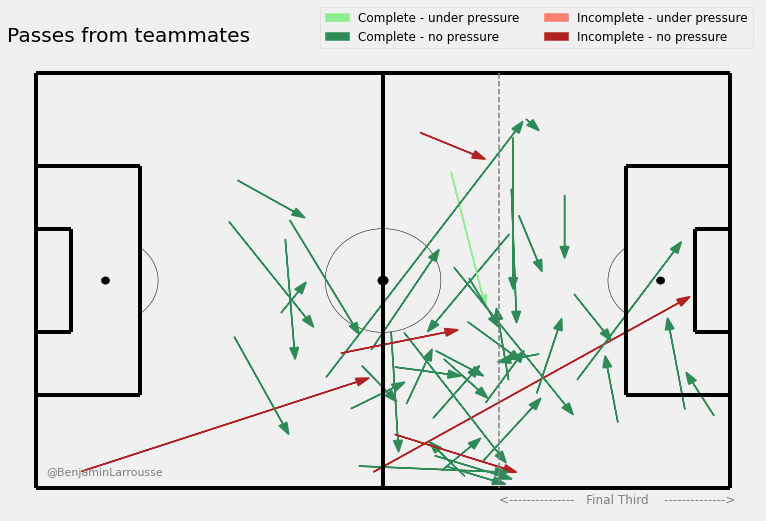

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
draw_pitch(ax)

for index, row in df_messi[(df_messi['match_id'] == match_id_min_xg) &
                           (df_messi['type.name'] == 'Pass') &
                           (df_messi['pass.recipient.name'] == messi_name) &
                           (~df_messi['pass.type.name'].isin(['Throw-in', 'Kick Off']))
                           ].iterrows():
    if row['pass.outcome.name'] == 'Incomplete':
        if row['under_pressure'] == True:
            color = "salmon"
        else:
            color = "firebrick"
    else:
        if row['under_pressure'] == True:
            color = 'lightgreen'
        else:
            color = 'seagreen'
            
    ax.arrow(row['location_x'],
             row['location_y'],
             row['end_location_x'] - row['location_x'],
             row['end_location_y'] - row['location_y'],
             color=color,
             linewidth=1.5,
             head_width=1.5,
             length_includes_head=True
             )
    
greenPatch_up = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'lightgreen')
redPatch_up = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'salmon')

greenPatch = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'seagreen')
redPatch = matplotlib.patches.Rectangle((0, 0), 0, 0, color = 'firebrick')

leg = ax.legend([greenPatch_up, greenPatch, redPatch_up, redPatch],
                ['Complete - under pressure', 'Complete - no pressure',
                 'Incomplete - under pressure', 'Incomplete - no pressure'],
                loc='upper right',
                bbox_to_anchor = (1, 1.1),
                fontsize=12,
                ncol=2)

plt.plot([80, 80], [0, 80],
         color='grey',
         linewidth=1.5,
         linestyle='--'
         )

plt.text(80, 83, "<---------------   Final Third    -------------->",
         {'color': 'grey', 'fontsize': 12})

ax.set_title(f"Passes from teammates",
            loc='left')

fig.savefig(f"{derby_folder}to_messi_passmap.png")

#### Passes Allowed Per Defensive Action (PPDA)

##### PPDA calculation

In [28]:
# Cutting the pitch
x_min_cut = range(0, 120, 20)
x_max_cut = range(20, 121, 20)

# Empty dataframe creation for result
ppda_df = pd.DataFrame(columns=['match_id','x_min', 'x_max', 'ppda_barca', 'ppda_opponent'])

# For all matches from 2009/2010, calculate PPDA
for match_id in tqdm(match_id_0910):
    ppda = []
    for x_min, x_max in zip(x_min_cut, x_max_cut):
        ppda_window = calculate_ppda(df_messi,
                                     match_id,
                                     x_min, x_max,
                                     0.0, 80.0)
        opponent = [list(ppda_window.keys()
                         )[0] if list(ppda_window.keys()
                                      )[0] != 'Barcelona' else list(ppda_window.keys()
                                                                    )[1]][0]
        ppda.append([match_id, x_min, x_max, ppda_window['Barcelona'], ppda_window[opponent]
                     ])

    temp_df = pd.DataFrame(data=ppda,
                           columns=['match_id','x_min', 'x_max', 'ppda_barca', 'ppda_opponent'])
    
    ppda_df = ppda_df.append(temp_df, ignore_index=True)

ppda_df.head()

,match_id,x_min,x_max,ppda_barca,ppda_opponent
0,69239,0,20,2.068966,1.088235
1,69239,20,40,1.479167,1.338983
2,69239,40,60,2.139535,2.825397
3,69239,60,80,2.181818,5.024390
4,69239,80,100,1.560000,3.939394


##### PPDA visualization for a particular match

PPDA of Barcelona during the derby, compared to average of the 2009/2010 season

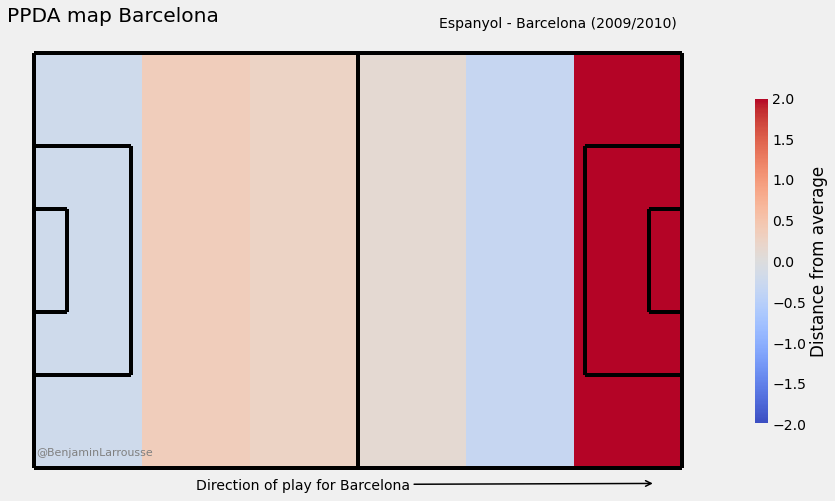

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
draw_pitch(ax)

minima = -2
maxima = 2

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap= 'coolwarm')

plt.colorbar(mapper, shrink=0.7, label='Distance from average')

for index, row in ppda_df[ppda_df['match_id'] == match_id_min_xg].iterrows():
    mean_ppda = ppda_df[(ppda_df['x_min'] == row['x_min']) &
                        (ppda_df['x_max'] == row['x_max'])
                        ]['ppda_barca'].mean()
    # Create a Rectangle patch
    rect = patches.Rectangle((row['x_min'], 0),
                             row['x_max'] - row['x_min'],
                             80,
                             linewidth=1,
                             edgecolor='none',
                             facecolor=mapper.to_rgba(row['ppda_barca']-mean_ppda),
                             label=row['ppda_barca'])

    # Add the patch to the Axes
    ax.add_patch(rect)
    
ax.set_title("PPDA map Barcelona",
            loc='left')

ax.annotate(f"Espanyol - Barcelona (2009/2010)",
            xy=(75, -5))

ax.annotate("Direction of play for Barcelona",
            xy=(115, 83), xytext=(30, 84),
            arrowprops=dict(arrowstyle="->", edgecolor='k', linewidth=1.5),
            color='k')

fig.savefig(derby_folder + 'ppda_barcelona.png')